In [36]:
!pip install shap
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


# import

In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier 
from catboost import CatBoostClassifier, Pool
import shap
from scipy.interpolate import interp1d
shap.initjs()

# Data Prep

In [6]:
!pip install -q kaggle

In [11]:
# you can find dataset at: https://www.kaggle.com/competitions/titanic/data?select=test.csv
from google.colab import files
files.upload()

Saving titanic.zip to titanic.zip


{'titanic.zip': b'PK\x03\x04-\x00\x00\x00\x08\x00&\x12\x8bOA\xaa\xebr\xff\xff\xff\xff\xff\xff\xff\xff\x15\x00\x14\x00gender_submission.csv\x01\x00\x10\x00\xba\x0c\x00\x00\x00\x00\x00\x00h\x03\x00\x00\x00\x00\x00\x00-\x961\x8e\x1d7\x10Ds\x03\xbe\xc9\x06S\xd5$\xbby\x04g\x02t\x02\x01Z\x08J\x1cH\xb0\xce\xef\xbf[/*p\xf6\xe3\xa1\x9a3O\xad/\xdf~\xff~\xff\xf7\xc7\xfb\xaf\x7f\xbe\xbf}\xfd\xef\xd7\x9f\x9f\x7f\xde\xbf\xff\xfd\xd7\\\xbf=\x1fQo\xfa\x88\x95\xd3N\x9c<\xec\x9c&\xa7\xfbq\xba\xcf\xf3q\xba\x8frr\xa2\x12+\x7f\xdb9\x9d\x9c:1y\x18\x8aB\x91\x12\xa1(\x14\x85\xa2P\x14\x8a:\xa7\xc9)\x14?\x89tq(\x0e\xc5\xa1x\'N\x1e\x86\xe2P|?\xa3B\xa9P*\x94\n\xa5V"\x94J\x97\n\xa52Q\xa5\xcb\xcaD+\x13\xadPV(+]V(+]V(+\x94\x15\xcaN\x97\x1d\xca\x0ee\x87\xb2\xd3e\x87\xb2C\xd9\xb9\xdd\x9d\x89v(\'\x94\x13\xcaq"\x94\x93.\'\xb7{2\xd1I\x97\x93.\'\xf7\xd2\xa1t(\x9d.\x1dJ\xa7K\x87\xd2\xe9\xd2\xa1t\xbat(\x93{\x99\xdc\xee\xa4\xcb\x842\xe92\xa1L(\x13\xca\x842\x99\xe8\x86rC\xb9\xa1\xdcP\xf2\xed\xde|\xbb7\xdf\xee\xcd\xb7{o&\xca\x

In [12]:
!unzip titanic.zip

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [13]:
# load data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [14]:
# dims of data
train_data.shape, test_data.shape

((891, 12), (418, 11))

Dataset is composed of 12 columns:
- __survival__ = Survival (0 = No, 1 = Yes, target)
- __pclass__ = Ticket class	(1 = 1st, 2 = 2nd, 3 = 3rd)
- __sex__ = Sex	
- __Age__ = Age in years	
- __sibsp__ = # of siblings / spouses aboard the Titanic	
- __parch__ = # of parents / children aboard the Titanic	
- __ticket__ = Ticket number	
- __fare__ = Passenger fare	
- __cabin__ = Cabin number	
- __embarked__ = Port of Embarkation	(C = Cherbourg, Q = Queenstown, S = Southampto)

In [15]:
X_all=pd.concat(
    [
        train_data[['PassengerId','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']],
        test_data[['PassengerId','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
     ]
).set_index('PassengerId')
y_train=train_data[['PassengerId','Survived']].set_index('PassengerId')['Survived']

In [16]:
X_all.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,3,male,22.0,1,0,7.2500,S
2,1,female,38.0,1,0,71.2833,C
3,3,female,26.0,0,0,7.9250,S
4,1,female,35.0,1,0,53.1000,S
5,3,male,35.0,0,0,8.0500,S


In [17]:
num_columns=['Age','SibSp','Parch','Fare']
cat_columns=list(filter(lambda x:x not in num_columns,X_all.columns))

In [18]:
# categorical features: finn nan's with string
X_all[cat_columns]=X_all[cat_columns].astype(str)
X_all[cat_columns]=X_all[cat_columns].fillna('NAN')

In [19]:
# data for catboost
X_train=X_all.iloc[:len(train_data),:]
X_test=X_all.iloc[len(train_data):]

# Split Data for train and test (validation)

We call the test as validation dataset because it is a kaggle competition

In [157]:
# data for logreg
X_train_lor=X_train.copy()
for col in num_columns:
    X_train_lor[col]=X_train_lor[col].fillna(X_train_lor[col].median())
X_train_lor=pd.get_dummies(X_train_lor, drop_first=True)

In [158]:
X_trn, X_val, y_trn, y_val = train_test_split(X_train, 
                                              y_train, 
                                              test_size=.2, 
                                              random_state=4321)
X_trn_lor = X_train_lor.loc[X_trn.index,:]
X_val_lor = X_train_lor.loc[X_val.index,:]

# Logistic Regression

In [159]:
lor = LogisticRegression(random_state=0, solver='lbfgs',max_iter=500).fit(X_trn_lor,y_trn)

In [160]:
print('accuracy:',accuracy_score(y_val,lor.predict(X_val_lor)))

accuracy: 0.8156424581005587


In [161]:
lor_coef = pd.Series(lor.coef_[0], index = X_trn_lor.columns)
lor_coef = pd.DataFrame({'exp(β)':lor_coef.apply(lambda x:np.exp(x))}).round(3)
lor_coef.style.apply(
    lambda x: [
        "background:orangered" if v<1 else "background:lightgreen"
        for v in x
        ], 
        axis = 1
)

,exp(β)
Age,0.963000
SibSp,0.694000
Parch,0.914000
Fare,1.004000
Pclass_2,0.449000
Pclass_3,0.179000
Sex_male,0.080000
Embarked_Q,0.651000
Embarked_S,0.580000
Embarked_nan,1.154000


## Random Forest

In [162]:
rf_model = RandomForestClassifier(n_estimators=500)
rf_model.fit(X_trn_lor,y_trn)

RandomForestClassifier(n_estimators=500)

In [163]:
print('accuracy:',accuracy_score(y_val, rf_model.predict(X_val_lor)))

accuracy: 0.8491620111731844


In [164]:
rf_model.classes_

array([0, 1])

# Catboost

In [165]:
cat_features=[X_trn.columns.to_list().index(col) for col in cat_columns]
cat = CatBoostClassifier(cat_features=cat_features,silent=True).fit(X_trn,y_trn)
probas_cat = pd.Series(cat.predict_proba(X_all)[:,1],index=X_all.index)

In [166]:
print('accuracy:',accuracy_score(y_val, cat.predict(X_val)))

accuracy: 0.8770949720670391


# Permutation Importance Random Forest

In [174]:
from sklearn.inspection import permutation_importance

In [177]:
%%time
result = permutation_importance(
    rf_model, X_val_lor, y_val,
    n_repeats=100,
    random_state=0
)

CPU times: user 1min 6s, sys: 183 ms, total: 1min 6s
Wall time: 1min 9s


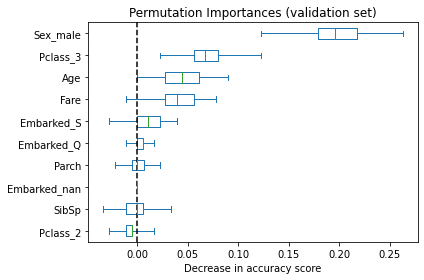

In [179]:
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_val_lor.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (validation set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

# Shap on Random Forest

In [167]:
%%time
shap_explainer = shap.TreeExplainer(rf_model)
shap_values = shap_explainer(X_val_lor)

CPU times: user 4.77 s, sys: 8.29 ms, total: 4.78 s
Wall time: 4.77 s


In [168]:
X_val_lor.head()

,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Embarked_nan
PassengerId,,,,,,,,,,
92,20.0,0,0,7.8542,0,1,1,0,1,0
42,27.0,1,0,21.0000,1,0,0,0,1,0
175,56.0,0,0,30.6958,0,0,1,0,0,0
528,28.0,0,0,221.7792,0,0,1,0,1,0
38,21.0,0,0,8.0500,0,1,1,0,1,0


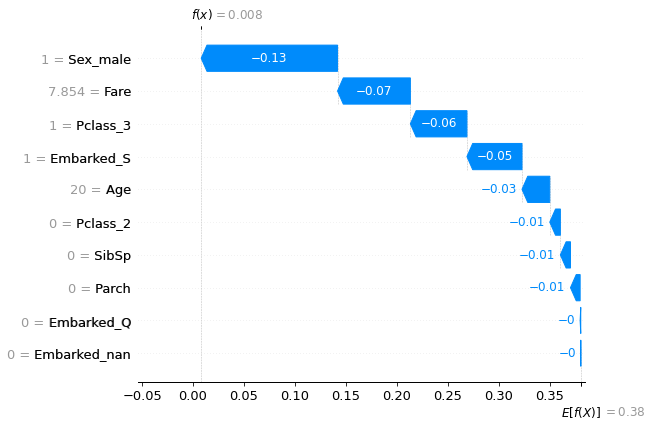

In [169]:
# waterfall plot for first observation
shap.plots.waterfall(shap_values[0][:, 1])

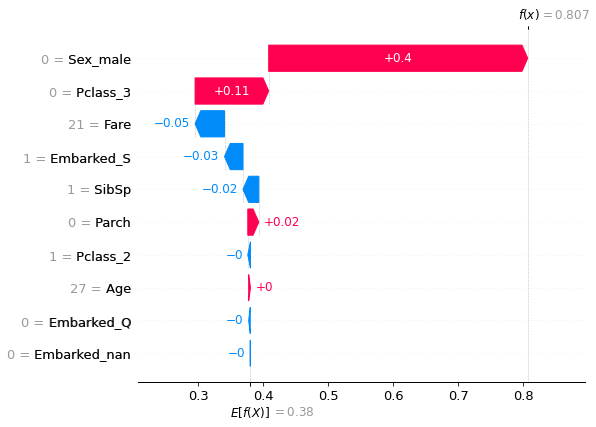

In [170]:
# waterfall plot for first observation
shap.plots.waterfall(shap_values[1][:, 1])

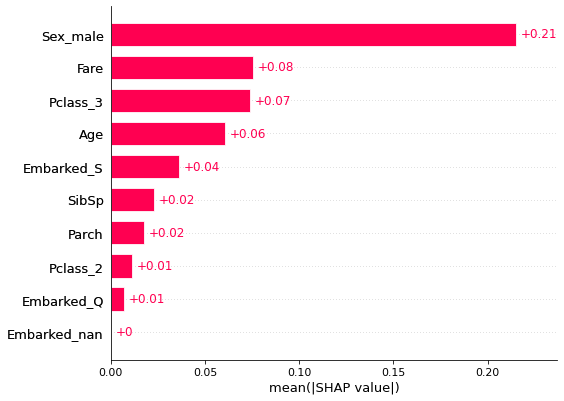

In [171]:
shap.plots.bar(shap_values[:, :, 1])

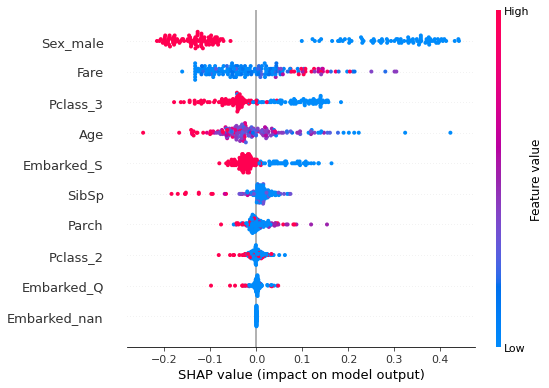

In [172]:
shap.summary_plot(shap_values[:, :, 1], X_val_lor)

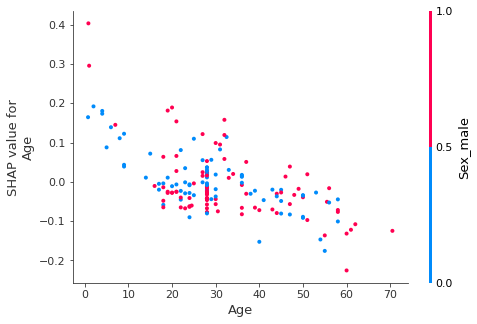

In [146]:
# We can pass a feature name instead of an index
shap.dependence_plot("Age", shap_values.values[:, :, 1], X_val_lor, interaction_index='Sex_male')

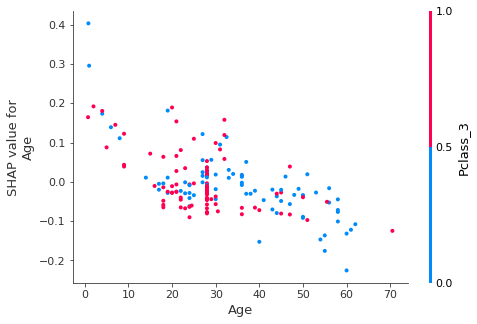

In [148]:
# We can pass a feature name instead of an index
shap.dependence_plot("Age", shap_values.values[:, :, 1], X_val_lor, interaction_index='Pclass_3')

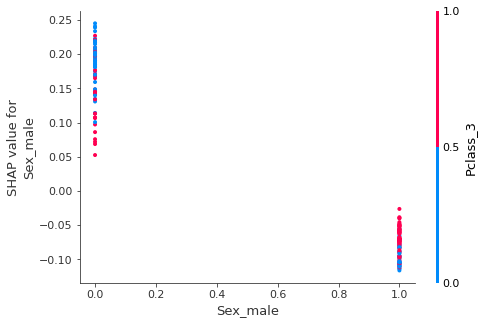

In [147]:
# We can pass a feature name instead of an index
shap.dependence_plot('Sex_male', shap_values.values[:, :, 1], X_val_lor)

# Shap on Catboost

In [84]:
%%time
shap_explainer_cat = shap.TreeExplainer(cat)
shap_values_cat = shap_explainer_cat(X_all)

CPU times: user 1.75 s, sys: 27 ms, total: 1.78 s
Wall time: 1.13 s


In [85]:
shap_values_cat[0]

.values =
array([-0.31455557, -0.69681198,  0.12307103,  0.02775474, -0.05326   ,
       -0.36327583, -0.09899252])

.base_values =
-0.5304167218891411

.data =
array(['3', 'male', 22.0, 1, 0, 7.25, 'S'], dtype=object)

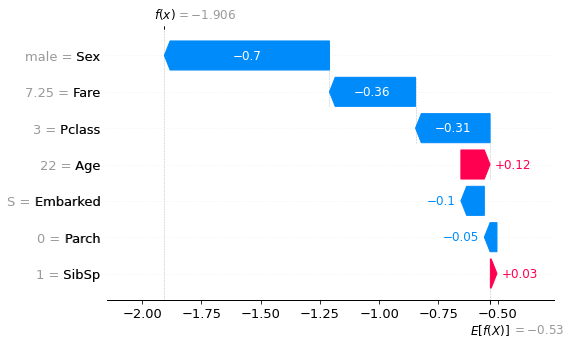

In [69]:
# waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

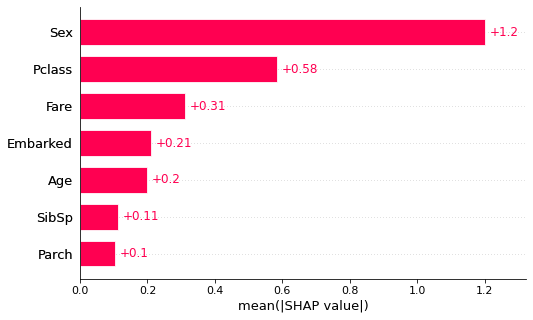

In [70]:
shap.plots.bar(shap_values)

In [173]:
X_all.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [71]:
# change Sex values
shap_values.data[shap_values.data == 'male'] = 0
shap_values.data[shap_values.data == 'female'] = 1

# change Embarked values
shap_values.data[shap_values.data == 'S'] = 0
shap_values.data[shap_values.data == 'C'] = 1
shap_values.data[shap_values.data == 'Q'] = 0.5

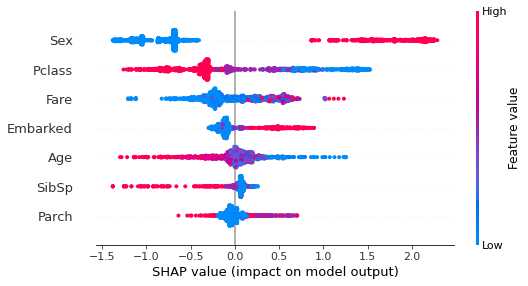

In [75]:
#beeswarm
shap.plots.beeswarm(shap_values)